In [1]:
#!pip install pyclustering
#!pip install openpyxl

## UC Irvine Machile Learning Repository: Online Retail  
- source: https://archive.ics.uci.edu/dataset/352/online+retail
- github repository:

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

Dataset Information

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.
Has Missing Values?
No

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Dataset Selection

In [2]:
# Load dataset
raw_online_retail = pd.read_csv('C:/Users/H S/Downloads/online_retail.csv', low_memory=False,skiprows=1)

In [3]:
raw_online_retail.shape

(541909, 8)

In [4]:
raw_online_retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom


## Data Cleaning and Preprocessing

In [5]:
# Check duplicated rows
len(raw_online_retail[raw_online_retail.duplicated])

5268

In [6]:
# Delete duplicate rows 
online_retail_2_miss=raw_online_retail.drop_duplicates(keep='last',inplace=False) 

In [7]:
n_rows, n_cols = online_retail_2_miss.shape
print(n_rows, n_cols)

536641 8


In [8]:
# Check for missing values
print(online_retail_2_miss.isna().values.any())
print(online_retail_2_miss.isnull().values.any())

True
True


In [9]:
online_retail_2_miss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


In [10]:
# Check missing values percetage 
n_missing_description=online_retail_2_miss['Description'].isnull().sum()
print('Missing fields in Description column:',round((n_missing_description*100)/n_rows,2),'%')

Missing fields in Description column: 0.27 %


In [11]:
n_missing_customer=online_retail_2_miss['CustomerID'].isnull().sum()
print('Missing fields in CustomerID column:',round((n_missing_customer*100)/n_rows,2),'%')

Missing fields in CustomerID column: 25.16 %


In [12]:
# Handle missing values CustomerID
online_retail_1_miss = online_retail_2_miss.dropna(subset=['CustomerID'],inplace=False)

In [13]:
# Handle missing values
online_retail_noise = online_retail_1_miss.dropna(subset=['Description'],inplace=False)

In [14]:
# Dropping not valuable columns
online_retail = online_retail_noise.drop(['InvoiceNo','StockCode','Description'],axis=1,inplace=False)

In [15]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Quantity     401604 non-null  int64  
 1   InvoiceDate  401604 non-null  object 
 2   UnitPrice    401604 non-null  float64
 3   CustomerID   401604 non-null  float64
 4   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 18.4+ MB


In [16]:
# Separate InvoiceDate 

online_retail['InvoiceDate'] = pd.to_datetime(online_retail['InvoiceDate'], format='%m/%d/%y %H:%M')
# Extract Date and Time separately
online_retail['Invoice_Date'] = online_retail['InvoiceDate'].dt.date      # Extract Date
online_retail['Invoice_Time'] = online_retail['InvoiceDate'].dt.time      # Extract Time
online_retail.head(2)
online_retail_sep=online_retail.drop(['InvoiceDate'],axis=1,inplace=False)

In [17]:
#Handle data types
online_retail_sep['Country'] = online_retail_sep['Country'].astype(str)

In [18]:
# Find the latest purchase date in the dataset
online_retail_sep['Invoice_Date'] = pd.to_datetime(online_retail_sep['Invoice_Date'], format='%m/%d/%y')
latest_date = online_retail_sep['Invoice_Date'].max()

# Compute Recency: Days since last purchase
recency_df = online_retail_sep.groupby('CustomerID').agg({'Invoice_Date': 'max'}).reset_index()
recency_df['Recency'] = (latest_date - recency_df['Invoice_Date']).dt.days
recency_df.drop(columns=['Invoice_Date'], inplace=True)  # Remove InvoiceDate column


In [19]:
online_retail_sep['Total_Spend'] = online_retail_sep['Quantity'] * online_retail_sep['UnitPrice']  # Compute total spend per transaction

# Create customer_df with other attributes
customer_df = online_retail_sep.groupby('CustomerID').agg({
    'Quantity': 'sum',         # Total quantity bought
    'Total_Spend': 'sum',      # Total money spent
    'Country': 'first'         # Keep customer's country
}).reset_index()

# Merge Recency into customer_df
customer_df = customer_df.merge(recency_df, on='CustomerID', how='left')
customer_df.head()

,CustomerID,Quantity,Total_Spend,Country,Recency
0,12346.0,0,0.00,United Kingdom,325
1,12347.0,2458,4310.00,Iceland,2
2,12348.0,2341,1797.24,Finland,75
3,12349.0,631,1757.55,Italy,18
4,12350.0,197,334.40,Norway,310


In [20]:
customer_df.shape

(4372, 5)

In [21]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   4372 non-null   float64
 1   Quantity     4372 non-null   int64  
 2   Total_Spend  4372 non-null   float64
 3   Country      4372 non-null   object 
 4   Recency      4372 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 170.9+ KB


In [22]:
# Encoding 
customer_df.drop('CustomerID',axis=1,inplace=True)

In [23]:
customer_df.head(2)

,Quantity,Total_Spend,Country,Recency
0,0,0.0,United Kingdom,325
1,2458,4310.0,Iceland,2


In [24]:
# Encoding 
customer_df_encoded = pd.get_dummies(customer_df, columns=['Country'], drop_first=True).astype(int)

In [25]:
customer_df_encoded.head(2)

,Quantity,Total_Spend,Recency,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,0,0,325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2458,4310,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# check on normal distribution
def isNormalDistributed(df,column):
    # Perform the Shapiro-Wilk test
    stat, p = shapiro(df[column])
    #print('Statistics=%.3f, p=%.3f' % (stat, p))
    # Interpretation of result
    if p > 0.05:
        print("Data is normally distributed")
    else:
        print("Data is not normally distributed")
#Plotting a histogram and a boxplot to show outliers
def hist_boxplot(df,column):
    # Generate sample continuous data
    data = df[column]
    
    # Create a figure with a shared axis for the histogram and box plot
    fig, ax = plt.subplots(2, 1, figsize=(4, 3), gridspec_kw={'height_ratios': [1, 4]})
    
    # Box plot (at the top)
    sns.boxplot(x=data, ax=ax[0], orient='h', color='skyblue')
    ax[0].set(xlabel='')
    
    # Histogram (at the bottom)
    ax[1].hist(data, bins=30, color='skyblue', edgecolor='black',density=True)
    ax[1].set_xlabel('Values')
    ax[1].set_ylabel('Density')
    
    # Title
    plt.suptitle('Boxplot and Histogram Column '+str(column))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show() 

Data is not normally distributed


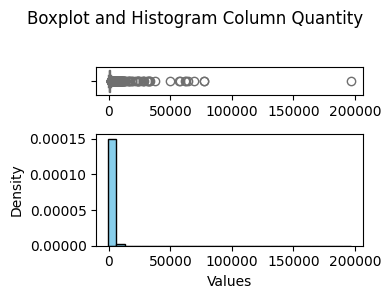

Data is not normally distributed


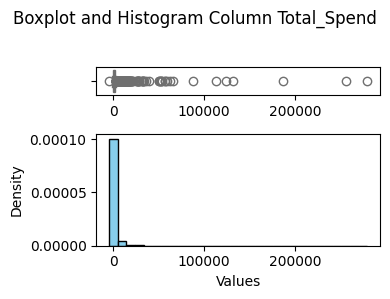

Data is not normally distributed


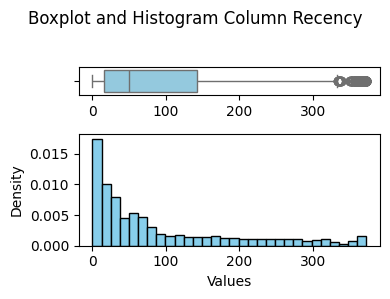

In [27]:
from scipy.stats import shapiro #determining distributions
for c in ['Quantity','Total_Spend','Recency']:
    isNormalDistributed(customer_df,c)
    hist_boxplot(customer_df,c)

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
customer_df_encoded[['Quantity', 'Total_Spend','Recency']] = scaler.fit_transform(customer_df_encoded[['Quantity', 'Total_Spend','Recency']])


In [29]:
customer_df_scaled = customer_df_encoded.copy()
customer_df_scaled.head(3)

,Quantity,Total_Spend,Recency,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,0.001538,0.015107,0.871314,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.014014,0.030295,0.005362,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.013420,0.021439,0.201072,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



### Dimensionality Reduction

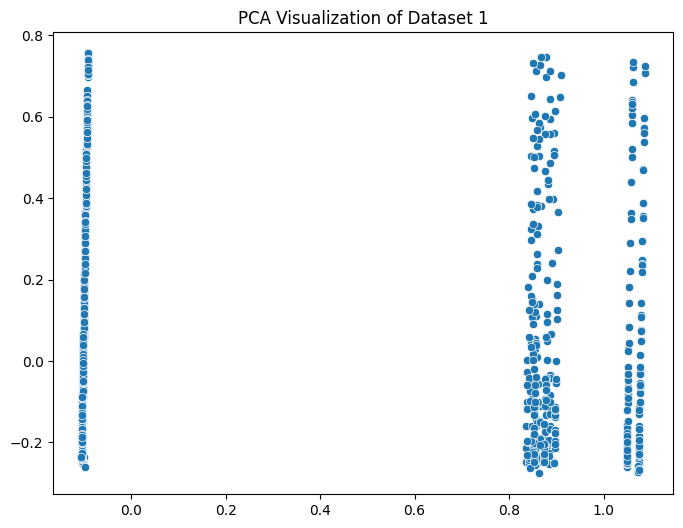

In [30]:
#Dimensionality Reduction using PCA
pca = PCA(n_components=2)
df1_pca = pca.fit_transform(customer_df_scaled)

# Visualize Dataset_1 PCA Results
plt.figure(figsize=(8,6))
sns.scatterplot(x=df1_pca[:, 0], y=df1_pca[:, 1])
plt.title("PCA Visualization of Dataset 1")
plt.show()

## Clustering Implementation



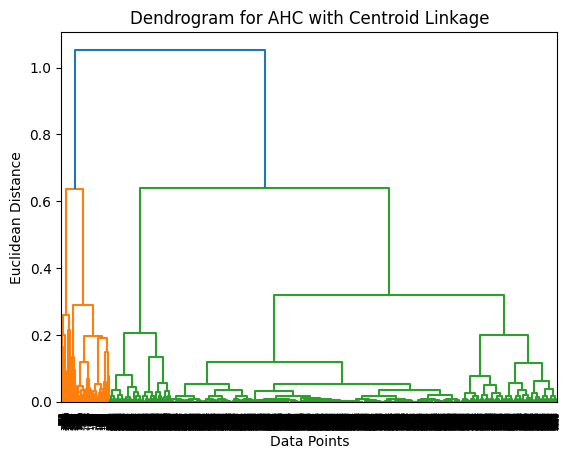

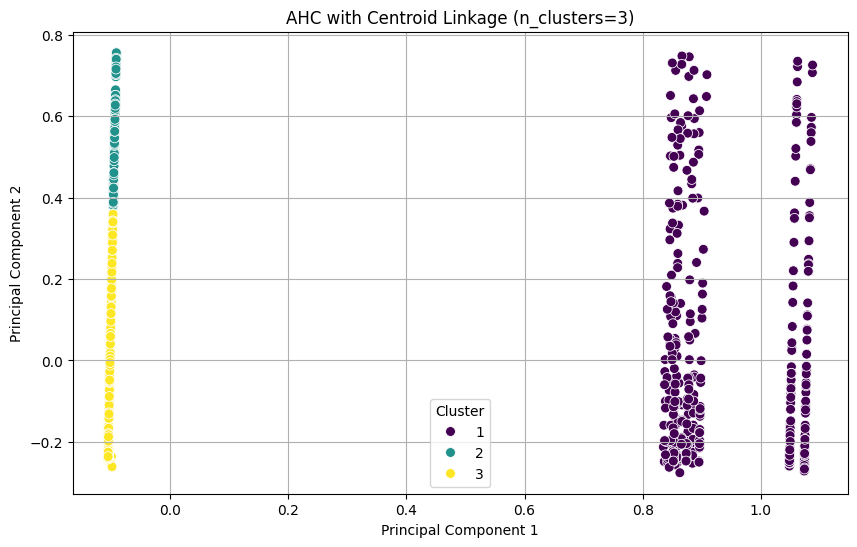

In [31]:
# Clustering Implementations

# Import necessary libraries
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist  # Import pdist for pairwise distance computation

## (ii) AHC with Centroid Linkage
distance_matrix = pdist(df1_pca, metric='euclidean')
linkage_matrix = linkage(distance_matrix, method='centroid')
dendrogram(linkage_matrix)
plt.title("Dendrogram for AHC with Centroid Linkage")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

n_clusters_ahc = 3  # Choose the number of clusters from dendrogram analysis
ahc_clusters = fcluster(linkage_matrix, n_clusters_ahc, criterion='maxclust')

# Visualize AHC results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df1_pca[:, 0], y=df1_pca[:, 1], hue=ahc_clusters, palette='viridis', s=50)
plt.title(f"AHC with Centroid Linkage (n_clusters={n_clusters_ahc})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc='best')
plt.grid(True)
plt.show()

In [32]:
# Cluster Validation

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_clustering(data, labels):
    """Evaluate clustering performance using multiple metrics."""
    silhouette_avg = silhouette_score(data, labels) if len(set(labels)) > 1 else None
    davies_bouldin = davies_bouldin_score(data, labels) if len(set(labels)) > 1 else None
    calinski_harabasz = calinski_harabasz_score(data, labels) if len(set(labels)) > 1 else None
    
    print(f"Silhouette Score: {silhouette_avg:.3f}" if silhouette_avg else "Silhouette Score: Not Applicable")
    print(f"Davies-Bouldin Index: {davies_bouldin:.3f}" if davies_bouldin else "Davies-Bouldin Index: Not Applicable")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}" if calinski_harabasz else "Calinski-Harabasz Index: Not Applicable")


print("\nAHC Evaluation:")
evaluate_clustering(df1_pca, ahc_clusters)


AHC Evaluation:
Silhouette Score: 0.686
Davies-Bouldin Index: 0.362
Calinski-Harabasz Index: 10172.134
